In [1]:
import numpy as np
import SimpleITK as sitk

import tempfile
import os
import shutil
import subprocess
import datetime
import time
from copy import deepcopy
from sklearn import mixture

import scipy.signal

Populating the interactive namespace from numpy and matplotlib


In [26]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [51]:
img_sitk = sitk.ReadImage("Case_041/NRRD/case_041_ax_space_trial.mha")
img = sitk.GetArrayFromImage(img_sitk)
pixel_ratio = img_sitk.GetSpacing()[2]/img_sitk.GetSpacing()[0]
print (pixel_ratio)

3.4133547465


In [71]:
tip_sitk = sitk.ReadImage("Case_041/cropped_tip_needle2.mha")
tip_sitk.SetOrigin(img_sitk.GetOrigin())
#tip_sitk.SetSpacing(img_sitk.GetSpacing())
tip_sitk.SetDirection(img_sitk.GetDirection())

tip = sitk.GetArrayFromImage(tip_sitk)

In [76]:
#tip_correlation = scipy.signal.correlate(img, tip)
tip_correlation_sitk = sitk.FFTNormalizedCorrelation(img_sitk, tip_sitk)

In [77]:
tip_correlation = sitk.GetArrayFromImage(tip_correlation_sitk)

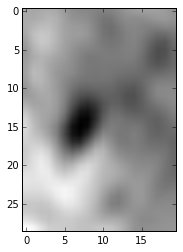

In [78]:
imshow(tip[3,:,:], cmap="gray")

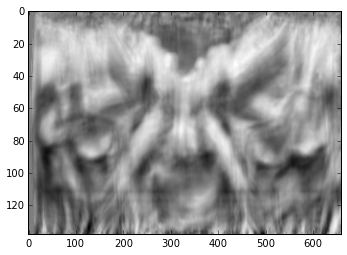

In [79]:
imshow(tip_correlation[:,200,:], cmap="gray", aspect=pixel_ratio)

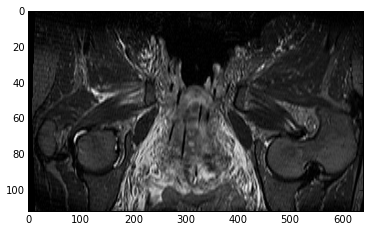

In [52]:
imshow(img[:,200,:], cmap="gray", aspect=pixel_ratio)

In [ ]:
def compute_frangi(img, min_sigma = 2, max_sigma = 8, itr = 7):
    
    tmp_dir = tempfile.mkdtemp()
    original_img_fn = "%s/original_img.nrrd" % (tmp_dir)
    filtered_img_fn = "%s/filtered_img.nrrd" % (tmp_dir)

    img_sitk = sitk.GetImageFromArray(img.astype(np.uint16))
    
    sitk.WriteImage(img_sitk, original_img_fn)
    
    frangi_cmd = "%s/Frangi3DFilter %s %s %f %f %d" % ("/home/imagenglab/shared_folder/needle_detection/itk_bin", 
                                                       original_img_fn, filtered_img_fn, min_sigma, max_sigma, itr)
    os.system(frangi_cmd)
        
    filtered_img = sitk.GetArrayFromImage(sitk.ReadImage(filtered_img_fn))
    
    filtered_img = filtered_img.reshape(img.shape)
    
    if os.path.exists(tmp_dir): shutil.rmtree(tmp_dir)
    
    return filtered_img

In [ ]:
frangi = compute_frangi(img)

In [ ]:
imshow(frangi[50,:,:], cmap="gray")

In [ ]:
imshow(img[50,:,:], cmap="gray")

In [ ]:
frangi_sitk = sitk.GetImageFromArray(frangi)
frangi_sitk.CopyInformation(img_sitk)
sitk.WriteImage(frangi_sitk, "Case_041/NRRD/Frangi.nrrd")

In [ ]:
g = mixture.GMM(n_components=3, n_init=3)

img_f = img.astype(np.float32)
img_f -= img.min()
img_f /= img.max()
img_f = img_f.flatten()

frangi_f = frangi.astype(np.float32).flatten()

X = np.asarray((img_f, frangi_f)).T

g.fit(X)
Y = g.predict(X)
labels = Y.reshape(img.shape)

In [ ]:
imshow(labels[50,:,:])